This notebook was inspired by neural network & machine learning labs led by [GMUM](https://gmum.net/).

See also [A Gentle Introduction to `torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) and the [video](https://www.youtube.com/watch?v=tIeHLnjs5U8) from 3Blue1Brown (the whole [playlist](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) is worth a watch).

# Automatic differentiation in PyTorch
Training neural networks happens in two stages:
- **Forward propagation** -- where the network makes its best guess about what the output should be. This is done by running the input data through the parametrized functions that constitute the network.
- **Backward propagation** -- where the network updates its parameters in proportion to the error of its guess. This is done by traversing backward from the output, collecting the derivatives of the error with respect to the parameters of the functions, and optimizing the parameters using gradient descent. 

We can also remind ourselves of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule) of calculus. If we have $L(x)=g(f(x))$, then:

$$\frac{d L(x)}{d x} = \frac{d L(x)}{ d f(x)} \frac{d f(x)}{d x}.$$

In the context of automatic differentiation in PyTorch what's important is that to calculate the gradient $\frac{d L(x)}{d x}$ we don't need to know anything about $g(x)$ if we know $\frac{d L(x)}{ d f(x)}$. If each module in PyTorch can keep track of its own gradient and be fed in the gradient from the next layer, then calculating the gradient of even a complicated function is possible in this chain-like manner.

In PyTorch each function that we use has these two methods:

- `forward`, which gets fed $x$ and calculates $f(x)$.
- `backward`, which gets fed $\frac{d L(x)}{ d f(x)}$ and calculates $\frac{d L(x)}{d x}$.

## Example 1: multiplication

Let's say we want to implement a new multiplication function $f(a,b)=a\cdot b$ in PyTorch and we want this function to be able to calculate its own derivatives.

To do that, we have to implement a `torch.autograd.Function` object with the methods:
- `forward`:
    1. Gets in `a` and `b`.
    2. Saves them for later to help with calculating gradients.
    3. Returns `a * b`.
- `backward`:
    1. Gets in `grad_output` (i.e. $\frac{d L(a,b)}{d f(a,b)}$).
    2. Retrieves `a` and `b` from memory.
    3. Calculates the derivative $\frac{d f(a,b)}{d a} = \frac{d (a \cdot b)}{d a}=b$.
    4. Calculates the derivative $\frac{d f(a,b)}{d b} = \frac{d (a \cdot b)}{d b}=a$.
    5. Returns the derivatives $\frac{d L(a,b)}{d f(a,b)}\frac{d f(a,b)}{d a}$ and $\frac{d L(a,b)}{d f(a,b)} \frac{d f(a,b)}{d b}$.

In [1]:
import torch

class MyProduct(torch.autograd.Function):
    
    @staticmethod
    def forward(self, a, b):
        self.save_for_backward(a, b)
        return a * b

    @staticmethod
    def backward(self, grad_output):
        # retrieve a and b from memory
        a, b = self.saved_tensors
        # calculate the derivative wrt a
        a_grad = b
        # calculate the derivative wrt b
        b_grad = a
        # return the derivatives
        return grad_output * a_grad, grad_output * b_grad

`torch.autograd.gradcheck` checks whether the gradients calculated by our function match with numerical estimates from small finite differences.

In [2]:
a = torch.randn(20, 30, dtype=torch.double, requires_grad=True) * 2 - 5
b = torch.randn(20, 30, dtype=torch.double, requires_grad=True) + 6

prod_fn = MyProduct.apply
assert torch.autograd.gradcheck(prod_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

## Example 2: ReLU
$\mathtt{ReLU}(x) = \max(x,0)$ is currently the most popular activation function in deep learning.

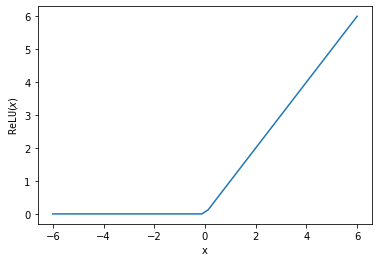

In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("x")
plt.ylabel("$\mathtt{ReLU}(x)$")
_ = plt.plot(np.linspace(-6, 6), np.maximum(np.linspace(-6, 6), 0))

In [4]:
class MyReLU(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        self.save_for_backward(x)
        return x.clamp(min=0)
    
    @staticmethod
    def backward(self, grad_output):
        x, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[x < 0] = 0
        return grad_input

relu_fn = MyReLU.apply
assert torch.autograd.gradcheck(relu_fn, a, eps=1e-6, atol=1e-4)

## Task 1 (1p)
Implement the following functions:
- `MyAdd(a, b): a + b`,
- `MyDiv(a, b): a / b`,
- `MySigmoid(x): 1 / (1 + exp(-x))`,
- `ReQU(x)`: $x^2$ for $x\geq0$ and $0$ for $x<0$.

In [5]:
class MyAdd(torch.autograd.Function):
    @staticmethod
    def forward(self, a, b):
        return a+b

    @staticmethod
    def backward(self, grad_output):
        return grad_output, grad_output

add_fn = MyAdd.apply
assert torch.autograd.gradcheck(add_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

In [6]:
class MyDiv(torch.autograd.Function):
    @staticmethod
    def forward(self, a, b):
        self.save_for_backward(a, b)
        return a / b

    @staticmethod
    def backward(self, grad_output):
        a, b = self.saved_tensors
        return grad_output / b, - a * grad_output / b ** 2

div_fn = MyDiv.apply
assert torch.autograd.gradcheck(div_fn, (a, b), eps=1e-3, atol=1e-2, rtol=1e-2)

In [7]:
class MySigmoid(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        self.save_for_backward(x)
        return 1 / (1 + torch.exp(-x))
    
    @staticmethod
    def backward(self, grad_output):
        x, = self.saved_tensors
        return grad_output * MySigmoid.forward(self, x) * (1 - MySigmoid.forward(self, x))

sigmoid_fn = MySigmoid.apply
assert torch.autograd.gradcheck(sigmoid_fn, a, eps=1e-3, atol=1e-2, rtol=1e-2)

In [8]:
class ReQU(torch.autograd.Function):
    @staticmethod
    def forward(self, x):
        self.save_for_backward(x)
        return x.clamp(min=0) ** 2
    
    @staticmethod
    def backward(self, grad_output):
        x, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[x < 0] = 0
        return 2 * grad_input * x
    
requ_fn = ReQU.apply
assert torch.autograd.gradcheck(requ_fn, a, eps=1e-3, atol=1e-6, rtol=1e-2)